# Validation of dynamic solver

The solution methods are implemented in lin_uvlm2d_dyn.solver, while tests are recorded in test_lindyn.py. Unless otherwise specified, a flat plate is always considered in these tests. The linearisation is about the 0 deg angle of attack position.

In [1]:
import numpy  as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
import uvlm2d_sta
import lin_uvlm2d_dyn
import pp_uvlm2d as pp
import analytical as an
import geo, set_dyn, set_gust

## Steady state:
This case looks at the solution at a steady angle of attack. The wake is used in the time-stepping procedure, but should have no impact on the solution accuracy. A very short wake is, therefore, used. Hall's correction (1994) should also have no impact on the results.

Done in 0.0 sec!
Done in 0.0 sec!
Done in 0.0 sec!
Done in 0.0 sec!
Done in 0.2 sec!
Done in 0.2 sec!


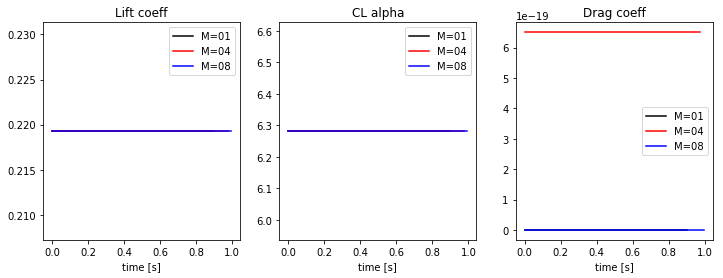

In [2]:
### random geometry
c=3.
b=0.5*c
uinf=20.0
T=1.0
WakeFact=2
alpha0=2.0
dalpha=0.0
alpha_tot=np.pi/180.*(alpha0+dalpha)
TimeList=[]
THCFList=[]
MList=[1,4,8]
for mm in range(len(MList)):
    M=MList[mm]

    ### reference solution (static)
    S0=uvlm2d_sta.solver(M=M,Mw=M*WakeFact,b=b,
         Uinf=np.array([uinf,0.]),alpha=alpha0*np.pi/180.,rho=1.225)
    S0.build_flat_plate()
    S0.eps_Hall=1.0 # no correction
    S0.solve_static_Gamma2d()
    ### linearisation
    Slin=lin_uvlm2d_dyn.solver(S0,T)
    Slin.solve_dyn_Gamma2d()
    # perturb reference state
    ZetaRot=geo.rotate_aerofoil(S0.Zeta,dalpha)
    dZeta=ZetaRot-S0.Zeta
    Slin.Zeta=dZeta
    for tt in range(Slin.NT):
        Slin.THZeta[tt,:,:]=dZeta
    # solve
    Slin.solve_dyn_Gamma2d()
    TimeList.append(Slin.time)
    THCFList.append(Slin.THFaero/S0.qinf/S0.chord)
clist=['k','r','b','0.6',]
fig = plt.figure('Aerodynamic forces',(12,4))
ax=fig.add_subplot(131)
for mm in range(len(MList)):
    ax.plot(TimeList[mm],THCFList[mm][:,1],clist[mm],label=r'M=%.2d'%MList[mm])
ax.set_xlabel('time [s]')
ax.set_title('Lift coeff')
ax.legend()
ax=fig.add_subplot(132)
for mm in range(len(MList)):
    ax.plot(TimeList[mm],THCFList[mm][:,1]/alpha_tot,clist[mm],label=r'M=%.2d'%MList[mm])
ax.set_xlabel('time [s]')
ax.set_title('CL alpha')
ax.legend()
ax=fig.add_subplot(133)
for mm in range(len(MList)):
    ax.plot(TimeList[mm],THCFList[mm][:,0],clist[mm],label=r'M=%.2d'%MList[mm])
ax.set_xlabel('time [s]')
ax.set_title('Drag coeff')
ax.legend()	
plt.show()

As expected:
- Hall's correction is not required. The correction, in fact, accumulates "net" vorticity at the last vortex. The nex vorticity in the wake is, however, null (despite the vortex rings carrying a non-zero vorticity, which is the accumulated vorticity at the aerofoil).
- Quantities remain constant, and the $CL_\alpha$ is always equal to $2\pi$. No induced drag, as expected.
- Interestingly, we get no jump in the aerodynamic force at the beginning of the simulation - which is, instead, a common feature of UVLM solvers.

Nothing changes when Hall's correction is introduced:

Done in 0.0 sec!
Done in 0.0 sec!
Done in 0.1 sec!
Done in 0.0 sec!
Done in 0.2 sec!
Done in 0.2 sec!


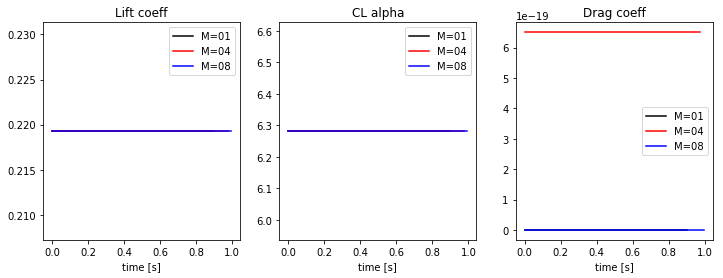

In [3]:
TimeList=[]
THCFList=[]
MList=[1,4,8]
for mm in range(len(MList)):
    M=MList[mm]

    ### reference solution (static)
    S0=uvlm2d_sta.solver(M=M,Mw=M*WakeFact,b=b,
         Uinf=np.array([uinf,0.]),alpha=alpha0*np.pi/180.,rho=1.225)
    S0.build_flat_plate()
    S0.eps_Hall=0.003
    S0.solve_static_Gamma2d()
    ### linearisation
    Slin=lin_uvlm2d_dyn.solver(S0,T)
    Slin.solve_dyn_Gamma2d()
    # perturb reference state
    ZetaRot=geo.rotate_aerofoil(S0.Zeta,dalpha)
    dZeta=ZetaRot-S0.Zeta
    Slin.Zeta=dZeta
    for tt in range(Slin.NT):
        Slin.THZeta[tt,:,:]=dZeta
    # solve
    Slin.solve_dyn_Gamma2d()
    TimeList.append(Slin.time)
    THCFList.append(Slin.THFaero/S0.qinf/S0.chord)
clist=['k','r','b','0.6',]
fig = plt.figure('Aerodynamic forces',(12,4))
ax=fig.add_subplot(131)
for mm in range(len(MList)):
    ax.plot(TimeList[mm],THCFList[mm][:,1],clist[mm],label=r'M=%.2d'%MList[mm])
ax.set_xlabel('time [s]')
ax.set_title('Lift coeff')
ax.legend()
ax=fig.add_subplot(132)
for mm in range(len(MList)):
    ax.plot(TimeList[mm],THCFList[mm][:,1]/alpha_tot,clist[mm],label=r'M=%.2d'%MList[mm])
ax.set_xlabel('time [s]')
ax.set_title('CL alpha')
ax.legend()
ax=fig.add_subplot(133)
for mm in range(len(MList)):
    ax.plot(TimeList[mm],THCFList[mm][:,0],clist[mm],label=r'M=%.2d'%MList[mm])
ax.set_xlabel('time [s]')
ax.set_title('Drag coeff')
ax.legend()	
plt.show()

There is no need of a comparison with the previous results as the y scale of these plots is relatively small. The match is perfect.

## Aerofoil in plunge motion

In this test case, the aerofoil has a zero angle of attack but an harmonic plunge motion is enforce. Lift is verified against Theodorsen solution, while the induced drag is checked against Garrik solution. Because the aerofoil has zero incidence the added mass force does not contribute to the induced drag as this is always perpendicular to the aerofoil panels. Below, tests are performed at both low and high frequency.

For brevity, no convergence study is reported. As a rule of thumb, results below use  "minimal" discretisation, i.e. enough to show a reasonable match between numerical and analytical solution but without making the tests presented in this section too computationally expensive.

### Low reduced frequency

In [ ]:
### random geometry
c=3.
b=0.5*c
ktarget=0.1
H=0.01*b
f0=2.#Hz
w0=2.*np.pi*f0 #rad/s
uinf=b*w0/ktarget
# Numerical solution
Ncycles=5.
WakeFact=16
T=2.*np.pi*Ncycles/w0
M=40

### reference static solution
S0=uvlm2d_sta.solver(M=M,Mw=M*WakeFact,b=b,
                       Uinf=np.array([uinf,0.]),alpha=0.0,rho=1.225)
S0.build_flat_plate()
S0.solve_static_Gamma2d()

# Linearised solution
Slin=lin_uvlm2d_dyn.solver(S0,T)
Slin=set_dyn.plunge(Slin,f0,H)
Slin.solve_dyn_Gamma2d()

### post-process
hc_num=(Slin.THZeta[:,0,1]-H)/S0.chord
aeffv_num=np.zeros((Slin.NT))
for tt in range(1,Slin.NT):
    aeffv_num[tt]=-np.arctan(
     (Slin.THZeta[tt,0,1]-Slin.THZeta[tt-1,0,1])/Slin.dt/S0.Uinf[0])  
THCF=Slin.THFaero/S0.qinf/S0.chord
THCFmass=Slin.THFaero_m/S0.qinf/S0.chord
THCFcirc=THCF-THCFmass        

### Analytical solution
hv_an=-H*np.cos(w0*Slin.time)
hc_an=hv_an/S0.chord
dhv=w0*H*np.sin(w0*Slin.time)
aeffv_an=np.arctan(-dhv/S0.Uabs)
# drag - Garrik
Cdv=an.garrick_drag_plunge(w0,H,S0.chord,S0.rho,uinf,Slin.time)
# lift - Theodorsen
Ltot_an,Lcirc_an,Lmass_an=an.theo_lift(
                              w0,0,H,S0.chord,S0.rho,S0.Uinf[0],0.0)
ph_tot=np.angle(Ltot_an)
ph_circ=np.angle(Lcirc_an)
ph_mass=np.angle(Lmass_an)
CLtot_an=np.abs(Ltot_an)*np.cos(w0*Slin.time+ph_tot)/(S0.chord*S0.qinf)
CLcirc_an=np.abs(Lcirc_an)*np.cos(w0*Slin.time+ph_circ)/(S0.chord*S0.qinf)
CLmass_an=np.abs(Lmass_an)*np.cos(w0*Slin.time+ph_mass)/(S0.chord*S0.qinf)  

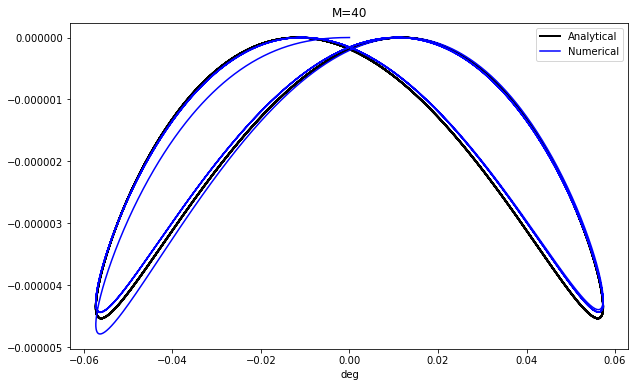

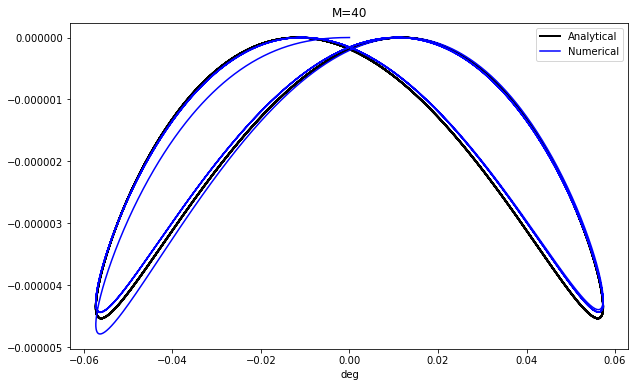

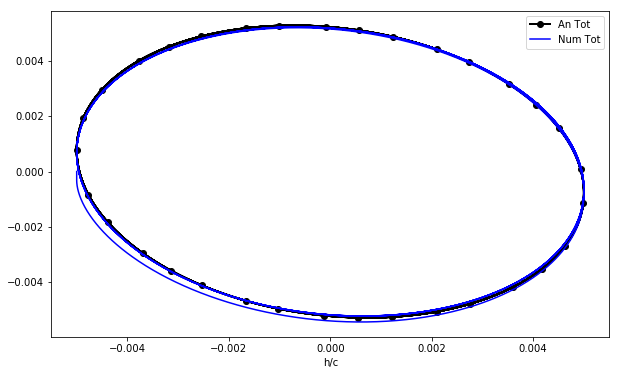

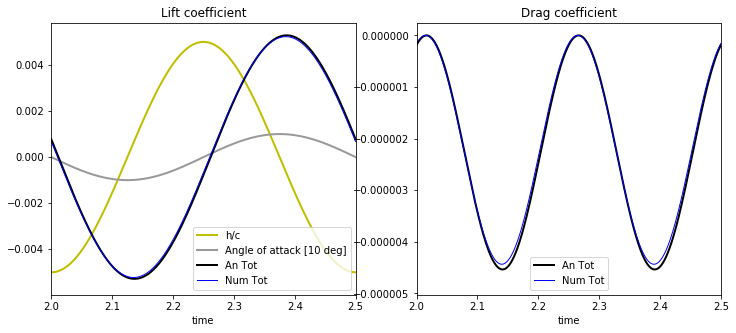

In [14]:
### Phase plots
fig = plt.figure('Induced drag in plunge motion -'
                                  ' Phase vs kinematics',(10,6))
ax=fig.add_subplot(111)
ax.plot(180./np.pi*aeffv_an,Cdv,'k',lw=2,label=r'Analytical')
ax.plot(180./np.pi*aeffv_num,THCF[:,0],'b',label=r'Numerical')
ax.set_xlabel('deg')
ax.set_title('M=%s'%M)
ax.legend()

aeffv_num=-np.arctan(Slin.THdZetadt[:,0,1]/S0.Uinf[0])
fig = plt.figure('Induced drag in plunge motion -'
                                  ' Phase vs kinematics - exact derivative',(10,6))
ax=fig.add_subplot(111)
ax.plot(180./np.pi*aeffv_an,Cdv,'k',lw=2,label=r'Analytical')
ax.plot(180./np.pi*aeffv_num,THCF[:,0],'b',label=r'Numerical')
ax.set_xlabel('deg')
ax.set_title('M=%s'%M)
ax.legend()
plt.show()

fig = plt.figure('Lift in plunge motion - '
                                   'Phase vs kinematics',(10,6))
ax=fig.add_subplot(111)
# analytical
ax.plot(hc_an,CLtot_an,'k',lw=2,marker='o',markevery=(.3),
                                                label=r'An Tot')
# numerical
ax.plot(hc_num,THCF[:,1],'b',label=r'Num Tot')
ax.set_xlabel('h/c')
ax.legend()

### Time histories
fig = plt.figure('Time histories',(12,5))
ax=fig.add_subplot(121)
ax.plot(Slin.time,hc_num,'y',lw=2,label='h/c')
ax.plot(Slin.time,aeffv_num,'0.6',lw=2,label='Angle of attack [10 deg]')
ax.plot(Slin.time,CLtot_an,'k',lw=2,label='An Tot')
ax.plot(Slin.time,THCF[:,1],'b',lw=1,label='Num Tot')
ax.set_xlabel('time')
ax.set_xlim((1.-1./Ncycles)*T, T)
ax.set_title('Lift coefficient')
ax.legend()
ax=fig.add_subplot(122)
ax.plot(Slin.time, Cdv,'k',lw=2,label='An Tot')
ax.plot(Slin.time, THCF[:,0],'b',lw=1,label='Num Tot')
ax.set_xlim((1.-1./Ncycles)*T, T)
ax.set_xlabel('time')
ax.set_title('Drag coefficient')
ax.legend()

plt.show() 

The match in both lift and drag is good, but drag convergence is slower than when a gemetrically-exact solution is used. The impact of Hall's correction is not shown but is almost insignificant as the wake is "long enough". In the phase plot, the numerical solution is plotted using the effective angle of attack $\tan{\zeta_z'/U_\infty}$ angle of attack, where $\zeta_z'$ is one of the input of the problem.

### High reduced frequency

Done in 446.0 sec!


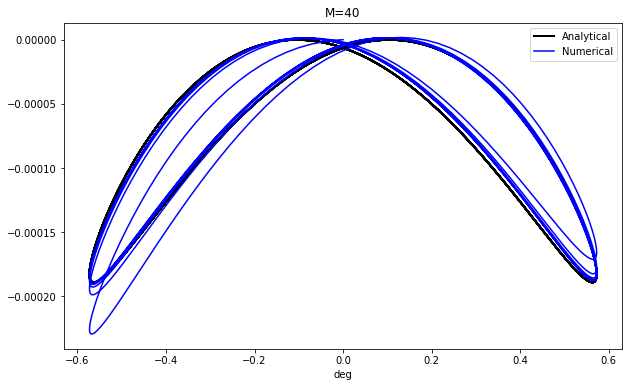

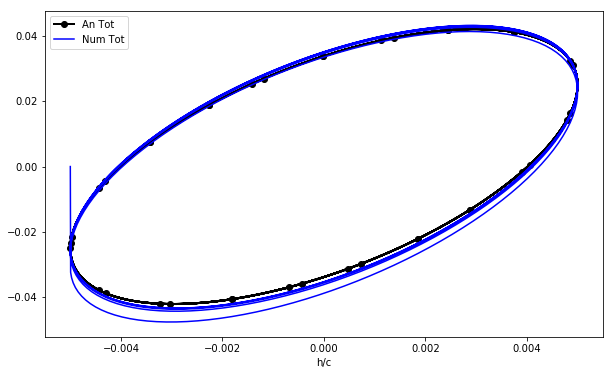

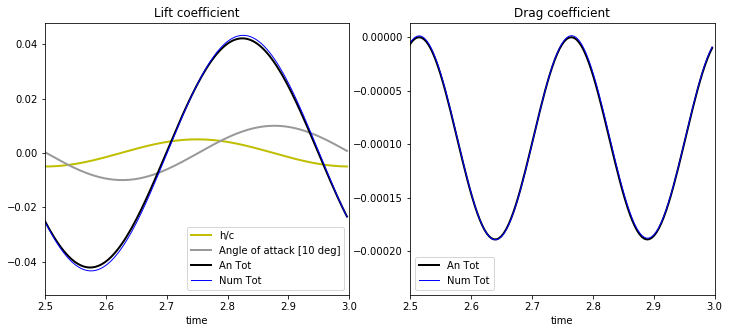

In [11]:
### random geometry
c=3.
b=0.5*c
ktarget=1.0
H=0.01*b
f0=2.#Hz
w0=2.*np.pi*f0 #rad/s
uinf=b*w0/ktarget
# Numerical solution
Ncycles=6.
WakeFact=20
T=2.*np.pi*Ncycles/w0
M=40

### reference static solution
S0=uvlm2d_sta.solver(M=M,Mw=M*WakeFact,b=b,
                       Uinf=np.array([uinf,0.]),alpha=0.0,rho=1.225)
S0.build_flat_plate()
S0.eps_Hall=0.003
S0.solve_static_Gamma2d()

# Linearised solution
Slin=lin_uvlm2d_dyn.solver(S0,T)
Slin=set_dyn.plunge(Slin,f0,H)
Slin.solve_dyn_Gamma2d()

### post-process
hc_num=(Slin.THZeta[:,0,1]-H)/S0.chord
aeffv_num=np.zeros((Slin.NT))
for tt in range(1,Slin.NT):
    aeffv_num[tt]=-np.arctan(
     (Slin.THZeta[tt,0,1]-Slin.THZeta[tt-1,0,1])/Slin.dt/S0.Uinf[0])  
THCF=Slin.THFaero/S0.qinf/S0.chord
THCFmass=Slin.THFaero_m/S0.qinf/S0.chord
THCFcirc=THCF-THCFmass        

### Analytical solution
hv_an=-H*np.cos(w0*Slin.time)
hc_an=hv_an/S0.chord
dhv=w0*H*np.sin(w0*Slin.time)
aeffv_an=np.arctan(-dhv/S0.Uabs)
# drag - Garrik
Cdv=an.garrick_drag_plunge(w0,H,S0.chord,S0.rho,uinf,Slin.time)
# lift - Theodorsen
Ltot_an,Lcirc_an,Lmass_an=an.theo_lift(
                              w0,0,H,S0.chord,S0.rho,S0.Uinf[0],0.0)
ph_tot=np.angle(Ltot_an)
ph_circ=np.angle(Lcirc_an)
ph_mass=np.angle(Lmass_an)
CLtot_an=np.abs(Ltot_an)*np.cos(w0*Slin.time+ph_tot)/(S0.chord*S0.qinf)
CLcirc_an=np.abs(Lcirc_an)*np.cos(w0*Slin.time+ph_circ)/(S0.chord*S0.qinf)
CLmass_an=np.abs(Lmass_an)*np.cos(w0*Slin.time+ph_mass)/(S0.chord*S0.qinf)

### Phase plots
fig = plt.figure('Induced drag in plunge motion -'
                                  ' Phase vs kinematics',(10,6))
ax=fig.add_subplot(111)
ax.plot(180./np.pi*aeffv_an,Cdv,'k',lw=2,label=r'Analytical')
ax.plot(180./np.pi*aeffv_num,THCF[:,0],'b',label=r'Numerical')
ax.set_xlabel('deg')
ax.set_title('M=%s'%M)
ax.legend()

fig = plt.figure('Lift in plunge motion - '
                                   'Phase vs kinematics',(10,6))
ax=fig.add_subplot(111)
# analytical
ax.plot(hc_an,CLtot_an,'k',lw=2,marker='o',markevery=(.3),
                                                label=r'An Tot')
# numerical
ax.plot(hc_num,THCF[:,1],'b',label=r'Num Tot')
ax.set_xlabel('h/c')
ax.legend()

### Time histories
fig = plt.figure('Time histories',(12,5))
ax=fig.add_subplot(121)
ax.plot(Slin.time,hc_num,'y',lw=2,label='h/c')
ax.plot(Slin.time,aeffv_num,'0.6',lw=2,label='Angle of attack [10 deg]')
ax.plot(Slin.time,CLtot_an,'k',lw=2,label='An Tot')
ax.plot(Slin.time,THCF[:,1],'b',lw=1,label='Num Tot')
ax.set_xlabel('time')
ax.set_xlim((1.-1./Ncycles)*T, T)
ax.set_title('Lift coefficient')
ax.legend()
ax=fig.add_subplot(122)
ax.plot(Slin.time, Cdv,'k',lw=2,label='An Tot')
ax.plot(Slin.time, THCF[:,0],'b',lw=1,label='Num Tot')
ax.set_xlim((1.-1./Ncycles)*T, T)
ax.set_xlabel('time')
ax.set_title('Drag coefficient')
ax.legend()

plt.show()  

A sufficiently refined grid provides a very good convergence.

## Impulsive start

This test shows the solution to Wagner's problem.

In [2]:
# set-up
M=6
WakeFact=20
c=3.
b=0.5*c
uinf=20.0
aeff=1.0*np.pi/180.
T=8.0

### reference static solution - at zero - Hall's correction
S0=uvlm2d_sta.solver(M=M,Mw=M*WakeFact,b=b,
                       Uinf=np.array([uinf,0.]),alpha=0.0,rho=1.225)
S0.build_flat_plate()
S0.solve_static_Gamma2d()

Slin1=lin_uvlm2d_dyn.solver(S0,T=T)
ZetaRot=geo.rotate_aerofoil(S0.Zeta,aeff)
dZeta=ZetaRot-S0.Zeta
Slin1.Zeta=dZeta
for tt in range(Slin1.NT):
    Slin1.THZeta[tt,:,:]=dZeta
Slin1._imp_start=True
Slin1.eps_Hall=0.003
Slin1.solve_dyn_Gamma2d()

### reference static solution - at zero - no Hall's correction
S0=uvlm2d_sta.solver(M=M,Mw=M*WakeFact,b=b,
                       Uinf=np.array([uinf,0.]),alpha=0.0,rho=1.225)
S0.build_flat_plate()
S0.solve_static_Gamma2d()

Slin2=lin_uvlm2d_dyn.solver(S0,T=T)
Slin2.Zeta=dZeta
for tt in range(Slin2.NT):
    Slin2.THZeta[tt,:,:]=dZeta
Slin2._imp_start=True
Slin2.eps_Hall=1.0
Slin2.solve_dyn_Gamma2d()

### Analytical solution
CLv_an=an.wagner_imp_start(aeff,uinf,c,Slin1.time)

##### Post-process numerical solution - Hall's correction
THCF=Slin1.THFaero/S0.qinf/S0.chord
# Mass and circulatory contribution
THCFmass=Slin1.THFaero_m/S0.qinf/S0.chord
THCFcirc=THCF-THCFmass

##### Post-process numerical solution - no Hall's correction
THCF2=Slin2.THFaero/S0.qinf/S0.chord
# Mass and circulatory contribution
THCFmass2=Slin2.THFaero_m/S0.qinf/S0.chord
THCFcirc2=THCF2-THCFmass2

Done in 4.5 sec!
Done in 4.4 sec!


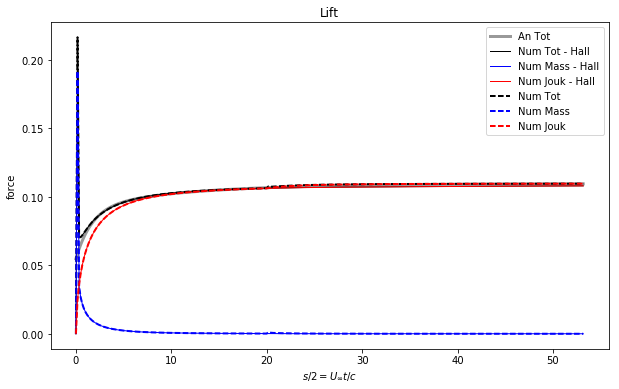

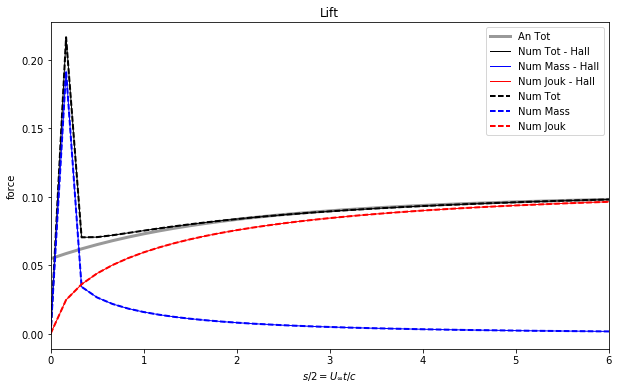

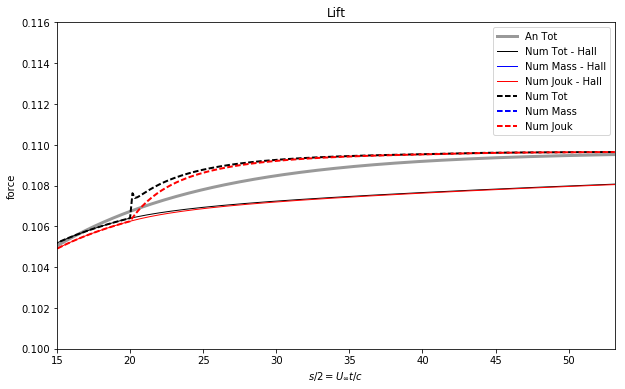

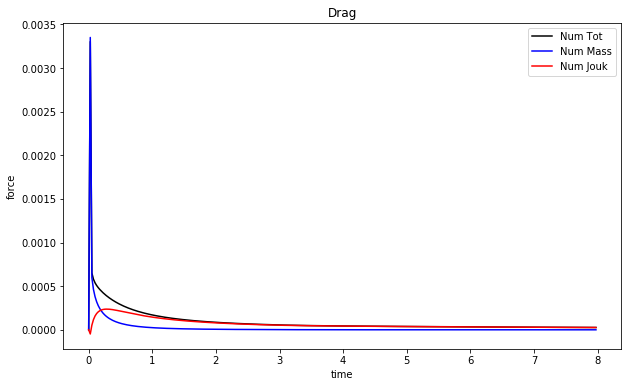

In [5]:
plt.close('all')
# non-dimensional time
sv=2.0*S0.Uabs*Slin1.time/S0.chord

fig = plt.figure('Lift coefficient',(10,6))
ax=fig.add_subplot(111)
# Wagner
ax.plot(0.5*sv, CLv_an,'0.6',lw=3,label='An Tot')
# numerical
ax.plot(0.5*sv, THCF[:,1],'k',lw=1,label='Num Tot - Hall')
ax.plot(0.5*sv, THCFmass[:,1],'b',lw=1,label='Num Mass - Hall')
ax.plot(0.5*sv, THCFcirc[:,1],'r',lw=1,label='Num Jouk - Hall')
# numerical
ax.plot(0.5*sv, THCF2[:,1],'k--',lw=2,label='Num Tot')
ax.plot(0.5*sv, THCFmass2[:,1],'b--',lw=2,label='Num Mass')
ax.plot(0.5*sv, THCFcirc2[:,1],'r--',lw=2,label='Num Jouk')
ax.set_xlabel(r'$s/2=U_\infty t/c$')
ax.set_ylabel('force')
ax.set_title('Lift')
ax.legend()

fig2 = plt.figure('Lift coefficient - zoom',(10,6))
ax=fig2.add_subplot(111)
# Wagner
ax.plot(0.5*sv, CLv_an,'0.6',lw=3,label='An Tot')
# numerical
ax.plot(0.5*sv, THCF[:,1],'k',lw=1,label='Num Tot - Hall')
ax.plot(0.5*sv, THCFmass[:,1],'b',lw=1,label='Num Mass - Hall')
ax.plot(0.5*sv, THCFcirc[:,1],'r',lw=1,label='Num Jouk - Hall')
# numerical
ax.plot(0.5*sv, THCF2[:,1],'k--',lw=2,label='Num Tot')
ax.plot(0.5*sv, THCFmass2[:,1],'b--',lw=2,label='Num Mass')
ax.plot(0.5*sv, THCFcirc2[:,1],'r--',lw=2,label='Num Jouk')
ax.set_xlabel(r'$s/2=U_\infty t/c$')
ax.set_ylabel('force')
ax.set_title('Lift')
ax.legend()
ax.set_xlim(0.,6.)

fig3 = plt.figure("Lift coefficient - Hall's correction effect",(10,6))
ax=fig3.add_subplot(111)
# Wagner
ax.plot(0.5*sv, CLv_an,'0.6',lw=3,label='An Tot')
# numerical
ax.plot(0.5*sv, THCF[:,1],'k',lw=1,label='Num Tot - Hall')
ax.plot(0.5*sv, THCFmass[:,1],'b',lw=1,label='Num Mass - Hall')
ax.plot(0.5*sv, THCFcirc[:,1],'r',lw=1,label='Num Jouk - Hall')
# numerical
ax.plot(0.5*sv, THCF2[:,1],'k--',lw=2,label='Num Tot')
ax.plot(0.5*sv, THCFmass2[:,1],'b--',lw=2,label='Num Mass')
ax.plot(0.5*sv, THCFcirc2[:,1],'r--',lw=2,label='Num Jouk')
ax.set_xlabel(r'$s/2=U_\infty t/c$')
ax.set_ylabel('force')
ax.set_title('Lift')
ax.legend()
ax.set_xlim(15.,0.5*sv[-1])
ax.set_ylim( 0.10, 0.116 )


fig = plt.figure('Drag coefficient',(10,6))
ax=fig.add_subplot(111)
ax.plot(Slin1.time, THCF[:,0],'k',label='Num Tot')
ax.plot(Slin1.time, THCFmass[:,0],'b',label='Num Mass')
ax.plot(Slin1.time, THCFcirc[:,0],'r',label='Num Jouk')
ax.set_xlabel('time')
ax.set_ylabel('force')
ax.set_title('Drag')
ax.legend()

plt.show()

It can be observed that:
- Hall's correction has an impact of the force time history: while it avoids the discontinuity occurring when the first vortex shed at the trailing edge reaches the end of the wake, it worsen the convergence at the steady state. A fine tuning may be required.
- At $t=0$ the aerodynamic force jumps to a very high value: this is compatible with the backward first order approximation of the time derivative in the code - the analytical solution assumes an infinite increase of the aerodynamic force at $t=0$. Also note that the jump in aerodynamic force is linked to the unsteady (added mass) term.

## Sinusoidal gust
Finally, we consider the response to a sinusoidal gust (Sears' solution). The impact of high/low frequencies/wavelength is not studied here. As in the previous cases, the aerofoil is set at a zero angle of attack.

In [4]:
# random geometry
c=3.
b=0.5*c

# gust profile
w0=0.01
uinf=2.0
L=10.0*c   # <--- gust wakelength

# discretisation
WakeFact=2
Ncycles=2 # number of "cycles"
Mfact=2
if c>L: M=np.ceil(4*Mfact*c/L)
else: M=Mfact*4

# Reference state
S0=uvlm2d_sta.solver(M=M,Mw=M*WakeFact,b=b,
                           Uinf=np.array([uinf,0.]),alpha=0.0,rho=1.225)
S0.build_flat_plate()
S0.solve_static_Gamma2d()

# Linearised model
Slin=lin_uvlm2d_dyn.solver(S0,T=Ncycles*L/uinf)
Slin=set_gust.sin(Slin,w0,L,ImpStart=False)
Slin.eps_Hall=1.0#0.003
Slin.solve_dyn_Gamma2d()
THCF=Slin.THFaero/S0.qinf/S0.chord

# Analytical solution
CLv = an.sears_lift_sin_gust(w0,L,uinf,c,Slin.time)	

TypeError: 'NoneType' object is not subscriptable

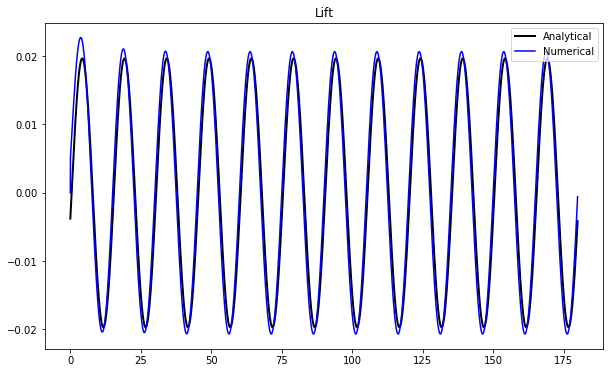

In [13]:
fig = plt.figure('Aerodynamic force coefficients',(10,6))
ax=fig.add_subplot(111)
ax.set_title(r'Lift')
ax.plot(Slin.time,CLv,'k',lw=2,label=r"Analytical")
ax.plot(Slin.time,THCF[:,1],'b',label=r'Numerical')
ax.legend()
plt.show()

The response amplitude matches reasonably but further checks, considering gust profiles of different length, should be performed.